In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('../Documents/datasets/Loan_default.csv')

## EDA

In [10]:
df.value_counts('Default', normalize=True)

Default
0    0.883872
1    0.116128
dtype: float64

In [16]:
df.groupby(['EmploymentType']).agg({'Default':'mean'})

,Default
EmploymentType,
Full-time,0.094634
Part-time,0.119652
Self-employed,0.114620
Unemployed,0.135529


<AxesSubplot:xlabel='CreditScore', ylabel='Density'>

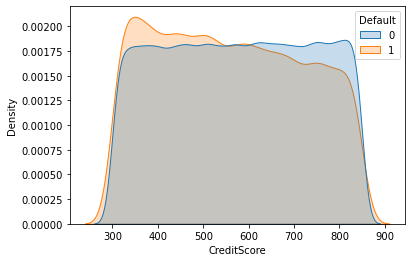

In [34]:
sns.kdeplot(data=df, x='CreditScore', hue='Default', common_norm=False, fill=True)

<AxesSubplot:xlabel='Age', ylabel='Density'>

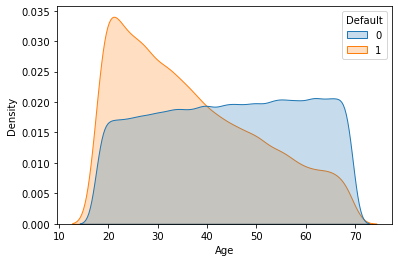

In [35]:
sns.kdeplot(data=df, x='Age', hue='Default', common_norm=False, fill=True)

<AxesSubplot:xlabel='LoanAmount', ylabel='Density'>

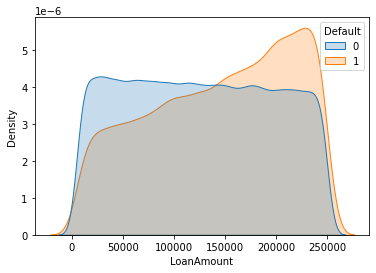

In [37]:
sns.kdeplot(data=df, x='LoanAmount', hue='Default', common_norm=False, fill=True)

<AxesSubplot:xlabel='MonthsEmployed', ylabel='Density'>

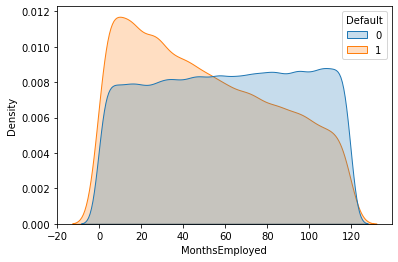

In [46]:
sns.kdeplot(data=df, x='MonthsEmployed', hue='Default', common_norm=False, fill=True)

In [55]:
df['TotalExpense'] = df['LoanAmount'] * (1 + (df['InterestRate']/12)/100)**df['LoanTerm']

In [63]:
df.TotalExpense.mean()

199558.18933024319

<AxesSubplot:xlabel='TotalExpense', ylabel='Density'>

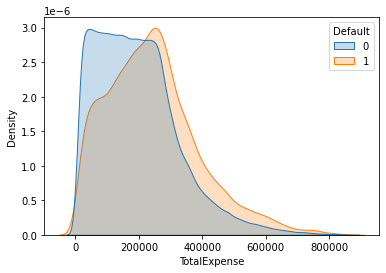

In [59]:
sns.kdeplot(data=df, x='TotalExpense', hue='Default', common_norm=False, fill=True)

In [65]:
df.groupby(['Education']).agg({'Default':'mean'})

,Default
Education,
Bachelor's,0.121011
High School,0.128789
Master's,0.108717
PhD,0.105860


In [83]:
df['ExcessMoney'] = df['TotalExpense'] - df['LoanAmount']

In [84]:
df.groupby('Default').agg({'ExcessMoney':'mean'})

,ExcessMoney
Default,
0,68493.765242
1,98508.499858


In [76]:
df.groupby(['Education']).value_counts(['EmploymentType'], normalize=True)

Education    EmploymentType
Bachelor's   Part-time         0.254218
             Unemployed        0.250443
             Self-employed     0.247708
             Full-time         0.247631
High School  Full-time         0.250270
             Self-employed     0.250239
             Unemployed        0.250223
             Part-time         0.249268
Master's     Full-time         0.251460
             Self-employed     0.250563
             Part-time         0.249713
             Unemployed        0.248265
PhD          Part-time         0.251853
             Unemployed        0.250862
             Self-employed     0.249461
             Full-time         0.247824
dtype: float64

## Model Prep

In [91]:
model_df = pd.get_dummies(df, columns=['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose'])

In [96]:
model_df['HasMortgage'] = model_df['HasMortgage'].apply(lambda x: 1 if x == 'Yes' else 0)
model_df['HasDependents'] = model_df['HasDependents'].apply(lambda x: 1 if x == 'Yes' else 0)
model_df['HasCoSigner'] = model_df['HasCoSigner'].apply(lambda x: 1 if x == 'Yes' else 0)

In [99]:
model_df = model_df.drop(columns=['LoanID', 'ExcessMoney'])

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, brier_score_loss, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold

import xgboost as xgb

### Random Forest

In [104]:
X = model_df.drop(columns=['Default'])
y = model_df.Default

In [105]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=4)

In [106]:
rf = RandomForestClassifier()
rf.fit(train_X, train_y)

RandomForestClassifier()

In [148]:
rf_preds = pd.Series(rf.predict(test_X))

In [149]:
confusion_matrix(rf_preds, test_y)

array([[44930,  5757],
       [  141,   242]])

In [150]:
f1_score(rf_preds, test_y)

0.0758382952052648

### XGBoost

In [139]:
xgb_model = xgb.XGBClassifier()

In [141]:
xgb_model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [142]:
xgb_preds = xgb_model.predict(test_X)

In [145]:
confusion_matrix(xgb_preds, test_y)

array([[44662,  5508],
       [  409,   491]])

In [151]:
f1_score(xgb_preds, test_y)

0.14233946948833165

### Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression

In [154]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

LogisticRegression()

In [155]:
lr_preds = lr.predict(test_X)

In [160]:
accuracy_score(lr_preds, test_y)

0.8828470726453886

## Resampling Data

In [161]:
from sklearn.utils import resample

In [166]:
df_majority = df[df.Default == 0]
df_minority = df[df.Default == 1]

In [169]:
df_minority_upsampled = resample(df_minority,
                                replace=True,
                                n_samples = len(df_majority),
                                random_state=4)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [170]:
df_upsampled.Default.value_counts()

1    225694
0    225694
Name: Default, dtype: int64